<a href="https://colab.research.google.com/github/summerolmstead/ML.A1.Olmstead/blob/main/ML_HW3_SummerOlmstead2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes: Hello! So I want to explain some things before you run this. For some reason when I had worked on this the night before I had no issues running it but then when I ran it again it started throwing errors about the tensor when I visualize the before and after it was saying it had to be a cpu tensor oddly enough because it wa stored in the cpu memory the model... Not sure so I did change the original code that had no issues working for days so if it does run into the issue when testing it i can give the code that worked before but I do not think it will be an issue. Secondly, I has having so many issues with the color RGB model just performing awful that I made a second grayscale model which is kind of better it is roughly .2 less in test loss. So I am submitting this homework with both models to showcase both of my attempts to have a better model. I tried to give better hyperparameters to RGB and I also dabbled into adding color processing as my model is lacking the ability to have vibrant colors but it did not turn out well so I took off the color enhancing packages.. I will submit the smaller training and testing sets onto github to be able to execute this code you will just need to follow the filepath and change it to your file path of where you save the zip folders. I will mention I believe the biggest reason the model generally is bad is because the model expects the input images to be 28x28 but the given original pictures for this asssignmet are often way higher pixelated so when it is converted to 28x28 pictures they are already extremely blurry and have nondistinct pictures feeding into the model so when enlarging this the model performs not the best. I hope this runs for you and does not throw any errors relating to the CPU though! Moreover, I did not use the original data and that is why i converted it to smaller subsets because one time one training session took 3 hours and on average the training time for these smaller subsets are 10 minutes so it is more practical. In addition, this could be a reason why the model does not perform well as I lowered the training images fromn 25k to just 4k and testing from 12.5k to 2k. Anyways, thanks for reading this and thank you for your time!

In [ ]:
#Another Note: For some reason everytime I logged into this code restarting my runtime I would be with the issue

Another Note: For some reason everytime I would execute the code for a new runtime there would be bugs in the code even if it was perfectly working the day before.. Before turning this in I tried to make sure it had no bugs.

Just getting Code to run in Model!

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here I created a smaller zip files of the given 12k test1 and 25k train images. It was taking to long to run with the model and was too inefficient to run on here also with the issue of surpassing usage limits to connect to GPU on google colab. The smaller.train.zip has 4k images roughly 2k of each cat and dog. The Test zip has 2k of both. Keep in mind, these both have photos from the original data given it is just a smaller subset.

In [ ]:
# Define the path to your zip files wherever you uploaded them (change directory as needed)
train_zip_path = "/content/drive/MyDrive/HW3ML/smaller.train.zip"
test_zip_path = "/content/drive/MyDrive/HW3ML/smaller.test.zip"

# Define the path where you want to extract the contents of the zip files (change directory as desired):
# Note: there will be tens of thousands of image files in each directory after extraction.
train_extraction_path = "/content/drive/MyDrive/HW3ML/smallTrain"
test_extraction_path = "/content/drive/MyDrive/HW3ML/smallTest"

In [ ]:
# Import the zipfile module and extract the contents:
# Note: This took me 5m 20s to run, expect to wait 5 minutes or longer while this completes
from zipfile import ZipFile

with ZipFile(train_zip_path, 'r') as zObject:
    zObject.extractall(path=train_extraction_path)
with ZipFile(test_zip_path, 'r') as zObject:
    zObject.extractall(path=test_extraction_path)

In [8]:
# Check to be sure the extraction occurred as expected.
# This code counts all the .jpg files in each directory.

# Expected results:
#   train: 25000 files
#   test1: 12500 files

# If your results don't match, try deleting the directory that
# failed and running the extraction code again on that directory.

import os
import fnmatch
train_file_count = len(fnmatch.filter(os.listdir("/content/drive/MyDrive/HW3ML/smallTrain/smaller.train"), '*.jpg'))
test_file_count = len(fnmatch.filter(os.listdir("/content/drive/MyDrive/HW3ML/smallTest/smaller.test"), '*.jpg'))
if train_file_count == 4060: #number of items in my subset
    train_text = ", success!"
else:
    train_text = ", failed to obtain all files."
if test_file_count == 2140: # # of items in my subset testing i made of original
    test_text = ", success!"
else:
    test_text = ", failed to obtain all files."
print("Train Files: " + str(train_file_count) + train_text)
print("Test Files: " + str(test_file_count) + test_text)

Train Files: 4060, success!
Test Files: 2140, success!


Okay now that we finally have the test and training done we can do the model to convert the images from 28x28 to 56x56

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import os
from PIL import Image

train_extraction_path = "/content/drive/MyDrive/HW3ML/smallTrain/smaller.train"

# PARAMETERS

#this is a list of many combinations of changing the parameters to take the model better
#better with ld=64,epoch=5,batch=128,capacity=64,lr=.0001
#moving ld and capacity from 64 to 128 lr=.0005, result .15
#ld and capacity to 100? .15 eh
#ld and capacity =90 and lr=.0001 not good
#ld,cap=128 ,lr=.0001,batch128 is awful
#265 ld cap took forever and model still sucks
#ok ld,cap=64 batch=128 lr=.0001 is terrible even worse somehow lol
#ld=100,e=5,batch=128,cap=100,lr=.00001 this is awful it gave no results??
#ld,cap=100,e=5,b=128,lr=.001 this is better not that bad

#i ended up sticking with this as it was probably the better results out of all else tried
latent_dims = 115
num_epochs = 5
batch_size = 128
capacity = 115
learning_rate = .001
use_gpu = True

#normalization
img_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28 pixels just incase if it isnt that size but should be
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#recall function to calculate layers
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc = nn.Linear(in_features=32 * 7 * 7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten batch of feature maps before going into latent dim
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=32 * 14 * 14)  # Adjust based on latent_dims
        self.conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)  # 14x14 -> 28x28
        self.conv1 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1)  # 28x28 -> 56x56

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 14, 14)  # Unflatten to feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))  # Use sigmoid for RGB image reconstruction
        return x

class RGB_Autoencoder(nn.Module):
    def __init__(self):
        super(RGB_Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

# Initialize the autoencoder model
autoencoder = RGB_Autoencoder()

# Move the model to GPU if available # i think its only using CPU because google colab told me i ran out of my limit usage LOL from running this often enough
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

# Define optimizer and loss function , similar to class example
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Update the paths to point directly to the directories containing image files
train_extraction_path = "/content/drive/MyDrive/HW3ML/smallTrain/smaller.train"

# Training loop without labels (no labels necessary, unsupervised)
for epoch in range(num_epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for filename in os.listdir(train_extraction_path):  # Iterate over files in the directory
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter for image files
            image_path = os.path.join(train_extraction_path, filename)  # Get the full path to the image
            image = Image.open(image_path)
            image = img_transform(image).unsqueeze(0).to(device)  # Transform and add batch dimension

            optimizer.zero_grad()
            recon_image = autoencoder(image)

            # Resize the original image to match the output size for computing the loss , need this because cant compare a 28x28 original input image to 56x56 output image so must resize
            target_image = F.interpolate(image, size=(56, 56), mode='bilinear', align_corners=False)

            loss = criterion(recon_image, target_image)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Accumulate loss for this batch

    average_loss = total_loss / len(os.listdir(train_extraction_path))  # Calculate average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}')


Epoch [1/5], Average Loss: 0.2092067959704643
Epoch [2/5], Average Loss: 0.1704609126593514
Epoch [3/5], Average Loss: 0.1618179206052804
Epoch [4/5], Average Loss: 0.15778378448426136
Epoch [5/5], Average Loss: 0.1549610730336309


In [10]:
test_extraction_path = "/content/drive/MyDrive/HW3ML/smallTest/smaller.test"

import os

# Testing loop without labels (evaluate on test data)
autoencoder.eval()  # Set model to evaluation mode
test_loss = 0
total_images = 0
for filename in os.listdir(test_extraction_path):  # Iterate over files in the directory
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter for image files
        image_path = os.path.join(test_extraction_path, filename)  # Get the full path to the image
        image = Image.open(image_path)
        image_resized = image.resize((56, 56))  # Resize the original image to 56x56
        image_resized = img_transform(image_resized).unsqueeze(0).to(device)  # Transform and add batch dimension
        recon_image = autoencoder(image_resized)

        # Resize the original image to match the output size for computing the loss
        target_image = F.interpolate(image_resized, size=(56, 56), mode='bilinear', align_corners=False)

        test_loss += criterion(recon_image, target_image).item()
        total_images += 1

average_test_loss = test_loss / total_images
print(f'Average Test Loss: {average_test_loss}')


Average Test Loss: 0.1514011938634076


Showing Three Before and After Pictures!

Note: some runs are better than others when testing this! The best results tend to be of black cats or white cats. The same goes for dark or light dogs as it is more distinctive and the model recognizes that.

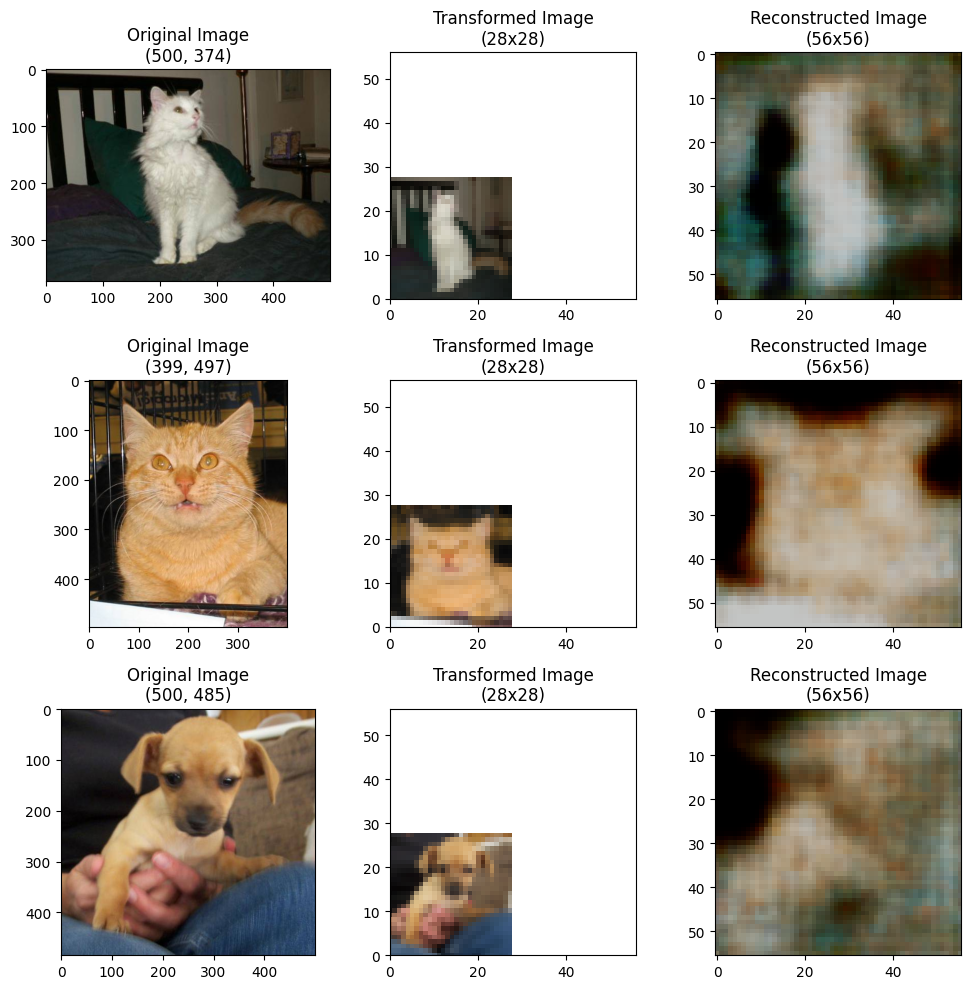

In [15]:
import numpy as np
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformations
img_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize original images to 28x28 pixels
    transforms.ToTensor(),
])

# Update the path to your training directory
train_path = "/content/drive/MyDrive/HW3ML/smallTrain/smaller.train"

# Get a list of image filenames from the training path
image_files = os.listdir(train_path)

# Randomly select three images from the list
sample_images = random.sample(image_files, 3)

# Plot the original images and their reconstructed versions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, image_file in enumerate(sample_images):
    # Load the original image
    original_image = Image.open(os.path.join(train_path, image_file))

    # Plot original image with dimensions
    axes[idx, 0].imshow(original_image)
    axes[idx, 0].set_title(f"Original Image\n{original_image.size}")
    axes[idx, 0].axis('on')  # Turn on axis for the original image

    # Apply transformations and move to the appropriate device
    transformed_image = img_transform(original_image).unsqueeze(0).to(device)

    # Pass through the model (assuming autoencoder is already defined and trained)
    reconstructed_image = autoencoder(transformed_image).to("cpu")

    # Plot transformed image (28x28)
    transformed_np = transformed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    axes[idx, 1].imshow(np.flipud(transformed_np))  # Plot the transformed image
    axes[idx, 1].set_title(f"Transformed Image\n(28x28)")
    axes[idx, 1].axis('on')  # Turn on axis for the transformed image
    axes[idx, 1].set_xlim(0, 56)
    axes[idx, 1].set_ylim(0, 56)  # Set y-axis limits from 0 to 56 to show before

    # Plot reconstructed image (56x56)
    reconstructed_np = reconstructed_image.squeeze(0).detach().numpy()
    axes[idx, 2].imshow(reconstructed_np.transpose(1, 2, 0))  # Plot the reconstructed image
    axes[idx, 2].set_title(f"Reconstructed Image\n(56x56)")
    axes[idx, 2].axis('on')  # Turn on axis for the reconstructed image
    axes[idx, 1].set_xlim(0, 56)
    axes[idx, 1].set_ylim(0, 56)  # Set y-axis limits from 0 to 56 to show before

plt.tight_layout()
plt.show()


Lets do it Grayscale to try to attempt to have better results

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from torchvision.transforms import transforms

train_extraction_path = "/content/drive/MyDrive/HW3ML/smallTrain/smaller.train"

# PARAMETERS
#.13 test loss . ld,cap,batch=128 , epoch=5,lr=.0001
#trying batch size 64, stopped working redoing all after changing var names

latent_dims = 100
num_epochs = 5
batch_size = 128
capacity = 100
learning_rate = 0.0001
use_gpu = True

# Define the transformations including grayscale conversion
img_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),  # Resize images to 28x28 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the encoder part of the autoencoder for grayscale images
class Grayscale_Encoder(nn.Module):
    def __init__(self):
        super(Grayscale_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc = nn.Linear(in_features=32 * 7 * 7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten batch of feature maps
        x = self.fc(x)
        return x

# Define the decoder part of the autoencoder for grayscale images
class Grayscale_Decoder(nn.Module):
    def __init__(self):
        super(Grayscale_Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=32 * 14 * 14)  # Adjust based on latent_dims
        self.conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)  # 14x14 -> 28x28
        self.conv1 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1)  # 28x28 -> 56x56

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 14, 14)  # Unflatten to feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))  # Use sigmoid for grayscale image reconstruction
        return x

# Define the full Grayscale_Autoencoder model
class Grayscale_Autoencoder(nn.Module):
    def __init__(self):
        super(Grayscale_Autoencoder, self).__init__()
        self.encoder = Grayscale_Encoder()
        self.decoder = Grayscale_Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

# Initialize the Grayscale_Autoencoder model
autoencoder2 = Grayscale_Autoencoder()

# Move the model to GPU if available
device2 = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder2 = autoencoder2.to(device2)

# Define optimizer and loss function
optimizer2 = torch.optim.Adam(autoencoder2.parameters(), lr=learning_rate)
criterion2 = nn.MSELoss()

# Training loop without labels
for epoch in range(num_epochs):
    total_loss2 = 0.0  # Initialize total loss for the epoch
    for filename in os.listdir(train_extraction_path):  # Iterate over files in the directory
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter for image files
            image_path = os.path.join(train_extraction_path, filename)  # Get the full path to the image
            image = Image.open(image_path)
            image = img_transform(image).unsqueeze(0).to(device2)  # Transform and add batch dimension

            optimizer2.zero_grad()
            recon_image2 = autoencoder2(image)

            # Resize the original image to match the output size for computing the loss
            target_image2 = F.interpolate(image, size=(56, 56), mode='bilinear', align_corners=False)

            loss2 = criterion2(recon_image2, target_image2)
            loss2.backward()
            optimizer2.step()

            total_loss2 += loss2.item()  # Accumulate loss for this batch

    average_loss2 = total_loss2 / len(os.listdir(train_extraction_path))  # Calculate average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss2}')


Epoch [1/5], Average Loss: 0.1851718387857832
Epoch [2/5], Average Loss: 0.15369501241386452
Epoch [3/5], Average Loss: 0.1454103543987415
Epoch [4/5], Average Loss: 0.1408601427268411
Epoch [5/5], Average Loss: 0.13814186816679525


In [17]:
test_extraction_path = "/content/drive/MyDrive/HW3ML/smallTest/smaller.test"

import os

# Testing loop without labels (evaluate on test data)
autoencoder2.eval()  # Set model to evaluation mode
test_loss2 = 0
total_images = 0
for filename in os.listdir(test_extraction_path):  # Iterate over files in the directory
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter for image files
        image_path = os.path.join(test_extraction_path, filename)  # Get the full path to the image
        image = Image.open(image_path)

        # Preprocess the image: resize, transform to tensor, and normalize
        image_resized2 = image.resize((56, 56))  # Resize the original image to 56x56
        image_resized2 = img_transform(image_resized).unsqueeze(0).to(device2)  # Transform and add batch dimension

        # Pass through the autoencoder
        recon_image2 = autoencoder2(image_resized2)

        # Resize the original image to match the output size for computing the loss
        target_image2 = F.interpolate(image_resized2, size=(56, 56), mode='bilinear', align_corners=False)

        # Compute and accumulate the test loss
        test_loss2 += criterion2(recon_image2, target_image2).item()
        total_images += 1

# Calculate the average test loss
average_test_loss2 = test_loss2 / total_images
print(f'Average Test Loss: {average_test_loss2}')


Average Test Loss: 0.10372502356767654


If you get a type error for some reason on the previous code for testing, try this instead - ran into this error right before i was going to turn this in . Could be a fluke for the machine executing it a bit differently but just incase if it doesnt work try this ! then proceed to the 3 test pics before and after :)

In [ ]:
test_extraction_path = "/content/drive/MyDrive/HW3ML/smallTest/smaller.test"

import os

# Testing loop without labels (evaluate on test data)
autoencoder2.eval()  # Set model to evaluation mode
test_loss2 = 0
total_images = 0
for filename in os.listdir(test_extraction_path):  # Iterate over files in the directory
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter for image files
        image_path = os.path.join(test_extraction_path, filename)  # Get the full path to the image
        image = Image.open(image_path)

        # Preprocess the image: resize, transform to tensor, and normalize
        image_resized = image.resize((56, 56))  # Resize the original image to 56x56
        image_resized_tensor = img_transform(image_resized).unsqueeze(0).to(device2)  # Transform and add batch dimension

        # Pass through the autoencoder
        recon_image2 = autoencoder2(image_resized_tensor)

        # Resize the original image to match the output size for computing the loss
        target_image2 = F.interpolate(image_resized_tensor, size=(56, 56), mode='bilinear', align_corners=False)

        # Compute and accumulate the test loss
        test_loss2 += criterion2(recon_image2, target_image2).item()
        total_images += 1

# Calculate the average test loss
average_test_loss2 = test_loss2 / total_images
print(f'Average Test Loss: {average_test_loss2}')

3 Photos to showcase results!

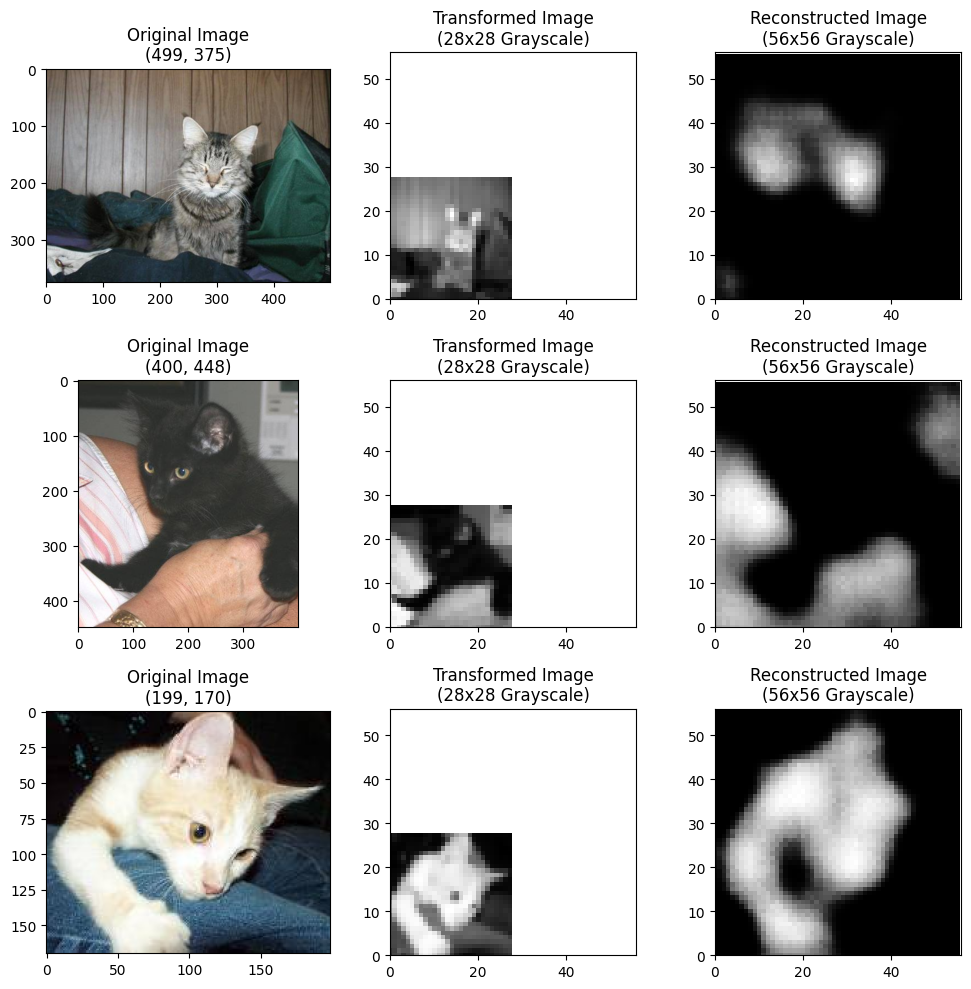

In [26]:
import numpy as np
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformations
img_transform2 = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize original images to 28x28 pixels
    transforms.Grayscale(),  # Convert images to grayscale
    transforms.ToTensor(),
])

# Update the path to your training directory
train_path = "/content/drive/MyDrive/HW3ML/smallTest/smaller.test"

# Get a list of image filenames from the training path
image_files2 = os.listdir(train_path)

# Randomly select three images from the list
sample_images2 = random.sample(image_files2, 3)

# Plot the original images and their reconstructed versions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, image_file in enumerate(sample_images2):
    # Load the original image
    original_image2 = Image.open(os.path.join(train_path, image_file))

    # Plot original image with dimensions
    axes[idx, 0].imshow(original_image2, cmap='gray')  # Display as grayscale
    axes[idx, 0].set_title(f"Original Image\n{original_image2.size}")
    axes[idx, 0].axis('on')  # Turn on axis for the original image

    # Apply transformations and move to the appropriate device
    transformed_image2 = img_transform(original_image2).unsqueeze(0).to(device2)

    # Pass through the model (assuming autoencoder is already defined and trained)
    with torch.no_grad():
        reconstructed_image2 = autoencoder2(transformed_image2).cpu()

    # Plot transformed image (28x28 grayscale)
    transformed_np2 = transformed_image2.squeeze(0).permute(1, 2, 0).cpu().numpy()
    axes[idx, 1].imshow(np.flipud(transformed_np2), cmap='gray')  # Flip and display as grayscale
    axes[idx, 1].set_title(f"Transformed Image\n(28x28 Grayscale)")
    axes[idx, 1].axis('on')  # Turn on axis for the transformed image
    axes[idx, 1].set_xlim(0, 56)
    axes[idx, 1].set_ylim(0, 56)  # Set y-axis limits from 0 to 56 to show before

    # Plot reconstructed image (56x56 grayscale)
    reconstructed_np2 = reconstructed_image2.squeeze(0).detach().numpy()
    axes[idx, 2].imshow(np.flipud(reconstructed_np2.transpose(1, 2, 0)), cmap='gray')  # Flip and display as grayscale
    axes[idx, 2].set_title(f"Reconstructed Image\n(56x56 Grayscale)")
    axes[idx, 2].axis('on')  # Turn on axis for the reconstructed image
    axes[idx, 2].set_xlim(0, 56)  # Set x-axis limits from 0 to 56
    axes[idx, 2].set_ylim(0, 56)  # Set y-axis limits from 0 to 56

plt.tight_layout()
plt.show()
